### **AutoEncoder**

- Unsupervised Learning 
- 입력을 저차원 잠재 공간(latent space)으로 압축 했다가 원본과 비슷한 출력으로 확장하여 재구성 하는 모델 


<img src="./variational-autoencoder-neural-network.png" width="700"/>

### **주요 목적**

- 차원 축소
- 노이즈 제거
- 특성 학습(feature learning)
- 이상치 탐지(anomaly detection)

### **기본 구조**

Input x ──▶ [Encoder] ──▶ z (잠재벡터) ──▶ [Decoder] ──▶ x̂ (재구성)

#### **Encoder**

- 여러 층의 신경망으로 입력 x -> 저차원 z 

#### **Decoder**
- z → 원본 x와 같은 차원으로 복원

### **Simple AutoEncoder**

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random
from sklearn.metrics import r2_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

In [18]:
idx_norm = [i for i, t in enumerate(mnist_train.targets) if t == 0]

In [20]:
idx_norm = [] 

for i, t in enumerate(mnist_train.targets):
    if t == 0:
        idx_norm.append(i)

In [4]:
valid_size = int(len(mnist_test) * 0.5)
test_size = len(mnist_test) - valid_size
mnist_valid, mnist_test = random_split(mnist_test, [valid_size, test_size])

batch_size = 32

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### **이미지 확인**

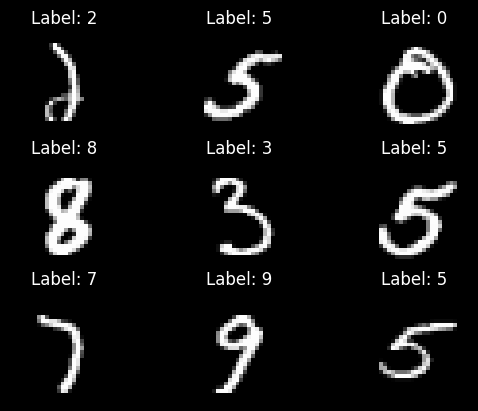

In [5]:
images = next(iter(train_loader))[:9]

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0][i][0], cmap='gray')
    plt.title(f"Label: {images[1][i]}")
    plt.axis('off')

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
        )            
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [8]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
epochs = 10


train_losses = []
valid_losses = []
for epoch in range(1, epochs + 1):
    model.train()
    
    train_loss = 0.0
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        optimizer.zero_grad()
        outs = model(x_train)
        loss = criterion(outs, x_train)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss /= len(train_loader)    # x /= y => x = x / y
    train_losses.append(train_loss)
    
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x_valid, y_valid in valid_loader:
            x_valid, y_valid = x_valid.to(device), y_valid.to(device)
            
            outs = model(x_valid)
            loss = criterion(outs, x_valid)
            
            valid_loss += loss.item()
            
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    scheduler.step()
    
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f}")

Epoch [1/10] Train Loss: 0.1270 Valid Loss: 0.0860
Epoch [2/10] Train Loss: 0.0794 Valid Loss: 0.0713
Epoch [3/10] Train Loss: 0.0686 Valid Loss: 0.0662
Epoch [4/10] Train Loss: 0.0671 Valid Loss: 0.0651
Epoch [5/10] Train Loss: 0.0660 Valid Loss: 0.0646
Epoch [6/10] Train Loss: 0.0659 Valid Loss: 0.0645
Epoch [7/10] Train Loss: 0.0657 Valid Loss: 0.0644
Epoch [8/10] Train Loss: 0.0657 Valid Loss: 0.0644
Epoch [9/10] Train Loss: 0.0657 Valid Loss: 0.0644
Epoch [10/10] Train Loss: 0.0657 Valid Loss: 0.0644


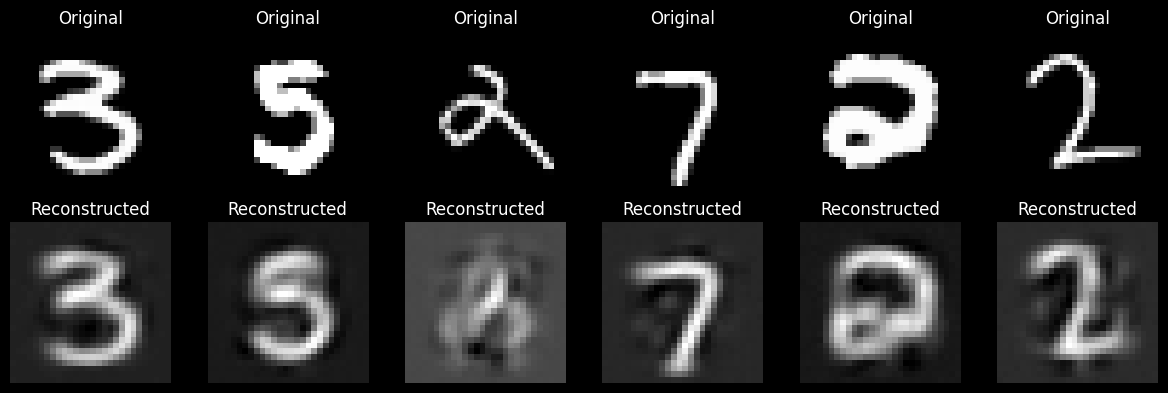

In [11]:
import matplotlib.pyplot as plt

model.eval()
test_iter = iter(test_loader)
x_test, _ = next(test_iter)
x_test = x_test.to(device)

# 복원 결과 얻기
with torch.no_grad():
    recon = model(x_test)

# 정규화 해제 ([-1, 1] → [0, 1])
x_test = x_test * 0.5 + 0.5
recon = recon * 0.5 + 0.5

# 시각화: 앞의 6개 비교
n = 6
plt.figure(figsize=(12, 4))
for i in range(n):
    # 원본
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].cpu().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # 복원
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].cpu().squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


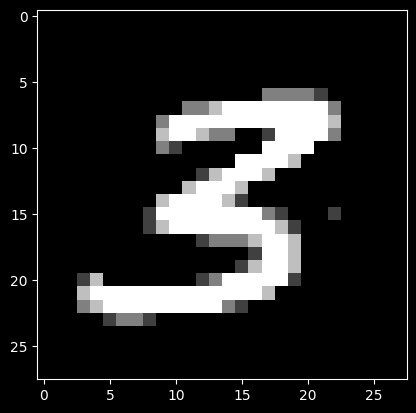

In [110]:
b = x_test * 0.5 + 0.5

plt.imshow(b[0].cpu().squeeze(), cmap = 'gray')